# Semantic Manifolds - Existence

For simplicitiy 

In [13]:
%%capture
import numpy as np
from data.generate import main 

words = ['dog', 'cat', 'mammal' ]
embeddings_raw = main(words)

## Dimensionality Reduction 

We then use an autoencoder to reduce the dimensionality from 1500 to 30.

In [31]:
from src.dimensionality_reduction.base import apply_pca

embeddings_pca = apply_pca(embeddings_raw, n_components=100)

Variance retained: 0.8009
Variance lost: 0.1991


In [2]:

from src.dimensionality_reduction.autoencoder import run_autoencoder

embeddings = np.array(embeddings_pca)
model, train_loss, test_loss = run_autoencoder(embeddings)



INFO:src.dimensionality_reduction.autoencoder:Epoch [1/500], Loss: 0.6204
INFO:src.dimensionality_reduction.autoencoder:Epoch [2/500], Loss: 0.4928
INFO:src.dimensionality_reduction.autoencoder:Epoch [3/500], Loss: 0.4908
INFO:src.dimensionality_reduction.autoencoder:Epoch [4/500], Loss: 0.4891
INFO:src.dimensionality_reduction.autoencoder:Epoch [5/500], Loss: 0.4887
INFO:src.dimensionality_reduction.autoencoder:Epoch [6/500], Loss: 0.4877
INFO:src.dimensionality_reduction.autoencoder:Epoch [7/500], Loss: 0.4861
INFO:src.dimensionality_reduction.autoencoder:Epoch [8/500], Loss: 0.4846
INFO:src.dimensionality_reduction.autoencoder:Epoch [9/500], Loss: 0.4815
INFO:src.dimensionality_reduction.autoencoder:Epoch [10/500], Loss: 0.4799
INFO:src.dimensionality_reduction.autoencoder:Epoch [11/500], Loss: 0.4793
INFO:src.dimensionality_reduction.autoencoder:Epoch [12/500], Loss: 0.4784
INFO:src.dimensionality_reduction.autoencoder:Epoch [13/500], Loss: 0.4774
INFO:src.dimensionality_reduction.

# Manifold Modeling

Once we have our embeddings, we can fit a von Mises-Fisher kernel to them.

In [32]:
import numpy as np
from scipy.special import iv  # For Bessel function

def von_mises_fisher_kernel(x, y, kappa):
    """
    Compute the von Mises-Fisher kernel value between two points on the hypersphere.
    :param x: Query point (normalized, unit vector)
    :param y: Data point (normalized, unit vector)
    :param kappa: Concentration parameter (controls spread)
    :return: Kernel value (float)
    """
    dot_product = np.dot(x, y)  # Cosine similarity
    return np.exp(kappa * dot_product)

def kernel_density_estimation(embedding, query_points, kappa):
    """
    Perform Kernel Density Estimation (KDE) on the hypersphere using von Mises-Fisher kernel.
    :param embedding: Numpy array of shape (N, n) where N is the number of data points, and n is the dimensionality.
    :param query_points: Numpy array of shape (M, n), points where density is estimated.
    :param kappa: Concentration parameter for the vMF kernel.
    :return: Array of density estimates at query points.
    """
    # Normalize the embeddings to ensure they lie on the hypersphere
    embedding = embedding / np.linalg.norm(embedding, axis=1, keepdims=True)
    query_points = query_points / np.linalg.norm(query_points, axis=1, keepdims=True)

    # Dimensionality of the hypersphere
    n = embedding.shape[1]
    
    # Compute the normalization constant for the vMF kernel
    normalization_const = (kappa**(n / 2 - 1)) / ((2 * np.pi)**(n / 2) * iv(n / 2 - 1, kappa))
    
    # Estimate the density for each query point
    densities = []
    for query in query_points:
        # Sum kernel values over all data points
        kernel_sum = np.sum([von_mises_fisher_kernel(query, point, kappa) for point in embedding])
        # Compute the density (normalized by the number of data points)
        density = normalization_const * kernel_sum / embedding.shape[0]
        densities.append(density)
    
    return np.array(densities)

# Example usage

# Query points where you want to estimate densities
query_points = embeddings[:10]  # Example: Take 10 points from the dataset as queries

# Concentration parameter for vMF kernel
kappa = 10  # Controls spread of the kernel

# Perform KDE
densities = kernel_density_estimation(embeddings, query_points, kappa)

# Print density estimates
print("Density estimates at query points:", densities)


Density estimates at query points: [30.12532044 34.13525559  5.83809548 20.96738774 15.78448873 19.24013336
 13.81742    16.45247538 20.89887789 29.72873494]


In [26]:
from scipy.stats import vonmises_fisher
import matplotlib.pyplot as plt
import numpy as np

embeddings_normalized = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)

# Fit a von Mises-Fisher distribution to the normalized data
# Note: You might need a specialized library or custom implementation for fitting
kappa, mu = vonmises_fisher.fit(embeddings_normalized)

# Print the parameters of the fitted von Mises-Fisher distribution

print(kappa, mu)

log_likelihood = np.sum(vonmises_fisher.logpdf(embeddings_normalized, kappa, mu))
print(f"Log-Likelihood on Test Data: {log_likelihood:.4f}")


[-0.48727203 -0.19318426 -0.28953519  0.12675414  0.01679457  0.07165896
 -0.24486181  0.11326826  0.10163631 -0.63829907  0.0089776  -0.16227919
 -0.16814474  0.24239601  0.05708041  0.03836722  0.05994638 -0.01339465
  0.08429552  0.01833881] 0.43467925054051615
Log-Likelihood on Test Data: 1498.7296


In [27]:
import numpy as np


# von Mises kernel
def von_mises_kernel(x, y, kappa):
    cosine_similarity = np.dot(x, y.T)
    return np.exp(kappa * cosine_similarity)

# Kernel density estimation
def von_mises_density(embeddings, query_points, kappa):
    densities = []
    for query in query_points:
        kernel_values = von_mises_kernel(embeddings, query, kappa)
        densities.append(np.mean(kernel_values))
    return np.array(densities)


kappa = 10  # Concentration parameter
densities = von_mises_density(embeddings, embeddings, kappa)


/var/folders/sn/hgygxn794qd6_mns52h0y2r40000gn/T/ipykernel_96444/2234788652.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(kappa * cosine_similarity)


In [28]:
# Identify points on the manifold where density exceeds threshold
def find_manifold(embeddings, query_points, kappa, threshold):
    densities = von_mises_density(embeddings, query_points, kappa)
    manifold_points = query_points[densities >= threshold]
    return manifold_points, densities

# Example: Extract the manifold
threshold = 0.05
manifold_points, manifold_densities = find_manifold(embeddings, embeddings, kappa, threshold)
print("Number of points on the manifold:", len(manifold_points))


Number of points on the manifold: 2250


/var/folders/sn/hgygxn794qd6_mns52h0y2r40000gn/T/ipykernel_96444/2234788652.py:7: RuntimeWarning: overflow encountered in exp
  return np.exp(kappa * cosine_similarity)


In [29]:
# Normalize the density over the manifold
def normalize_density(manifold_points, manifold_densities):
    total_density = np.sum(manifold_densities)
    normalized_densities = manifold_densities / total_density
    return normalized_densities

normalized_densities = normalize_density(manifold_points, manifold_densities)
print("Normalized densities:", normalized_densities)


Normalized densities: [nan nan nan ... nan nan  0.]


/var/folders/sn/hgygxn794qd6_mns52h0y2r40000gn/T/ipykernel_96444/636321772.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_densities = manifold_densities / total_density


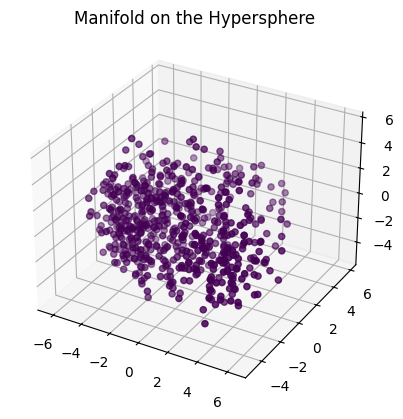

In [30]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Visualize the manifold in 3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(manifold_points[:, 0], manifold_points[:, 1], manifold_points[:, 2], c=normalized_densities, cmap='viridis')
plt.title("Manifold on the Hypersphere")
plt.show()


# Assessment 

We then assess the quality of the reduction using a variety of metrics.


In [3]:
from sklearn.manifold import trustworthiness
trust = trustworthiness(embeddings, umap_embeddings, n_neighbors=5)
print(f"Trustworthiness: {trust}")

# Extract Latent Representations
autoencoder = model
autoencoder.eval()
import torch            
with torch.no_grad():
    embeddings_tensor = torch.tensor(embeddings, dtype=torch.float32)
    latent_representations = autoencoder(embeddings_tensor)

latent_representations = latent_representations.numpy()
original_data = embeddings

# Local Structure: Trustworthiness
trust = trustworthiness(original_data, latent_representations, n_neighbors=10)
print(f"Trustworthiness: {trust}")

# Local Structure: Neighborhood Overlap (Jaccard Index)
def jaccard_index(original_data, latent_data, k=10):
    from sklearn.neighbors import NearestNeighbors
    nn_original = NearestNeighbors(n_neighbors=k, metric="cosine").fit(original_data)
    nn_latent = NearestNeighbors(n_neighbors=k, metric="cosine").fit(latent_data)
    original_neighbors = nn_original.kneighbors(return_distance=False)
    latent_neighbors = nn_latent.kneighbors(return_distance=False)
    overlaps = [
        len(set(original_neighbors[i]) & set(latent_neighbors[i])) / k
        for i in range(original_data.shape[0])
    ]
    return np.mean(overlaps)

jaccard = jaccard_index(original_data, latent_representations, k=10)
print(f"Jaccard Index: {jaccard}")

# Global Structure: Reconstruction Error
reconstructed = autoencoder(embeddings_tensor)
reconstruction_error = nn.MSELoss()(reconstructed, embeddings_tensor).item()
print(f"Reconstruction Error: {reconstruction_error}")

# Global Structure: Distance Preservation
from sklearn.metrics.pairwise import pairwise_distances
original_distances = pairwise_distances(original_data)
latent_distances = pairwise_distances(latent_representations)
distance_error = np.linalg.norm(original_distances - latent_distances) / np.linalg.norm(original_distances)
print(f"Distance Preservation Error: {distance_error}")


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Trustworthiness: 0.9725243334324511
